# Time series forecasting

### What is time series forecasting?
We will use time data to forecast (predict) upcoming COVID-19 cases for the Skåne region in Sweden.

### **Dataset**
Number of COVID-19 cases in Sweden per day and region. The dataset is from [Sveriges dataportal](https://www.dataportal.se/sv) and can be found [here](https://www.dataportal.se/sv/datasets/525_1424/antal-fall-av-covid-19-i-sverige-per-dag-och-region).

### What time frames are we looking at?
* Short term: Week
* Medium term: Few months
* Long term: Yearss


In [530]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [531]:
# Import data
#data = 'covid-cases.csv'
data = 'covid19.csv'
df = pd.read_csv(data)

# Lock Skåne column
skåne = df.iloc[:, 12:13]

# Lock date column
datum = df.iloc[:, -1:]

# Merge dataframes
df_covid = pd.merge(skåne, datum, left_index=True, right_index=True)
df_covid.head()

# Rename column Statistikdatum to Datum
df_covid.rename(columns={'Statistikdatum': 'Datum'}, inplace=True)

# Drop all zero values in the dataframe
df_covid = df_covid[(df_covid != 0).all(1)]

In [532]:
# Reverse order of dataframe
df_covid = df_covid.iloc[::-1]
df_covid.head()

,Skåne,Datum
274,1,02/03/2020
273,1,03/03/2020
272,7,04/03/2020
270,8,06/03/2020
269,5,07/03/2020


In [534]:
# Prepare dataframe
df_covid = pd.Series( df_covid['Skåne'].values, 
                    index=pd.DatetimeIndex(data= (tuple(pd.date_range('2020-03-02', periods=272, freq='D'))),
                                          freq='D'))

In [535]:
df_covid.head()

2020-03-02    1
2020-03-03    1
2020-03-04    7
2020-03-05    8
2020-03-06    5
Freq: D, dtype: int64

In [536]:
type(df_covid.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [537]:
# Check type of datum
#print("Datum data type: ", type(df_covid['Datum'][0]))

# Convert column Datum from string to datetime
#df_covid['Datum'] = pd.to_datetime(df_covid['Datum'], infer_datetime_format=True)

# Check type of datum
#print("Datum data type after converting: ", type(df_covid['Datum'][0]))

In [538]:
# Set date as the index of the dataframe
#df_covid = df_covid.set_index(['Datum'])

In [539]:
#df_covid = df_covid.iloc[::-1]

# Visualization and data exploration

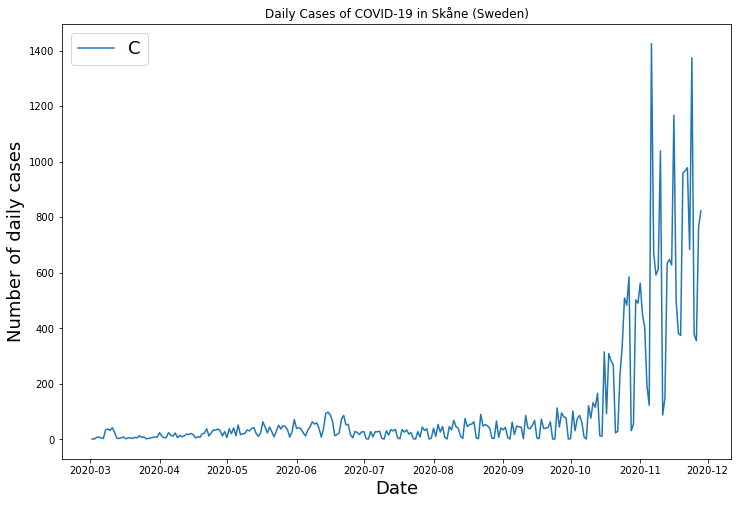

In [540]:
plt.figure(figsize=(12,8))
plt.plot(df_covid)
plt.title('Daily Cases of COVID-19 in Skåne (Sweden)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of daily cases', fontsize=18)
plt.legend('C', fontsize=18);

## Cumulative sums
The total sum of data as it grows with time.

In [541]:
# We need to reverse the dataframe to get the total sum counting from the first case
#reversed_df = df_covid.iloc[::-1]

In [542]:
# Save as a new dataframe
covid_cumulative = np.cumsum(df_covid)

In [543]:
# Last entries
covid_cumulative.tail()

2020-11-24    27261
2020-11-25    27638
2020-11-26    27993
2020-11-27    28758
2020-11-28    29581
Freq: D, dtype: int64

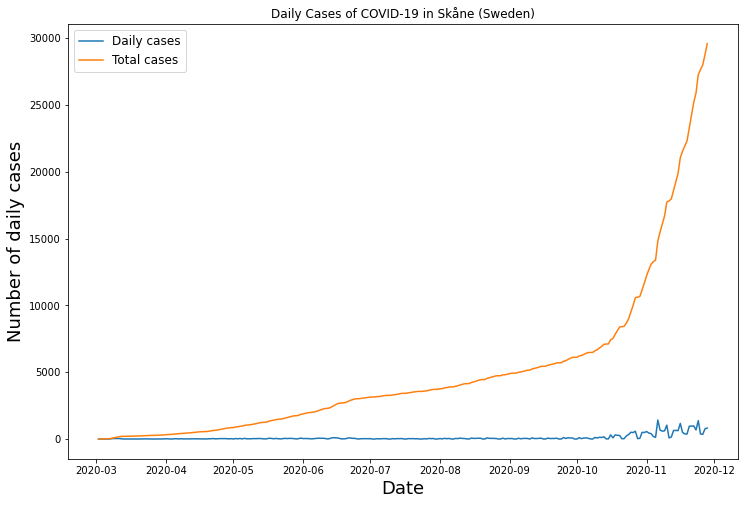

In [544]:
# Plot time series with cumulative
plt.figure(figsize=(12,8))
plt.plot(df_covid)
plt.plot(covid_cumulative)
plt.title('Daily Cases of COVID-19 in Skåne (Sweden)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of daily cases', fontsize=18)
plt.legend(['Daily cases', 'Total cases'], fontsize=12);

# Stationary vs non-stationary
* **Seasonality**: Variations that occur at specific regular intervals 
* **Trend**: Tendency of the data to increase or decrease during a longer period of time
* **Stationary**: No trends or seasonality, easier to model around
* **Non-stationary**: If there is seasonality or a trend to the time series it is non-stationary.
<br><br>
Let us test the dataset for stationarity.

## The Augmented Dickey-Fuller test 
* Statistical test called a unit root test
* Determines how strongly a time series is defined by a trend
* The p-value should be less than the significance level (say 0.05) in order for the time series to be stationary.

In [545]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(df):
    
    result=adfuller(df)
    output = pd.Series(result[0:1], index=['P-value'])
    
    if result[1] <= 0.05:
        print('---Dataset is stationary---')
        print(output)
        
    elif result[1] >= 0.05:
        print('---Dataset is non-stationary---')
        print(output)
    
    

In [546]:
stationarity_test(df_covid)

---Dataset is non-stationary---
P-value    2.730175
dtype: float64


## Autocorrelation
* Similarity between observations as a function of the time
* Correlation within the data on a time scale
<br><br>

We will test for autocorrelation in our data. <br>
If the plots are outside of the blue area it shows correlation in the data.

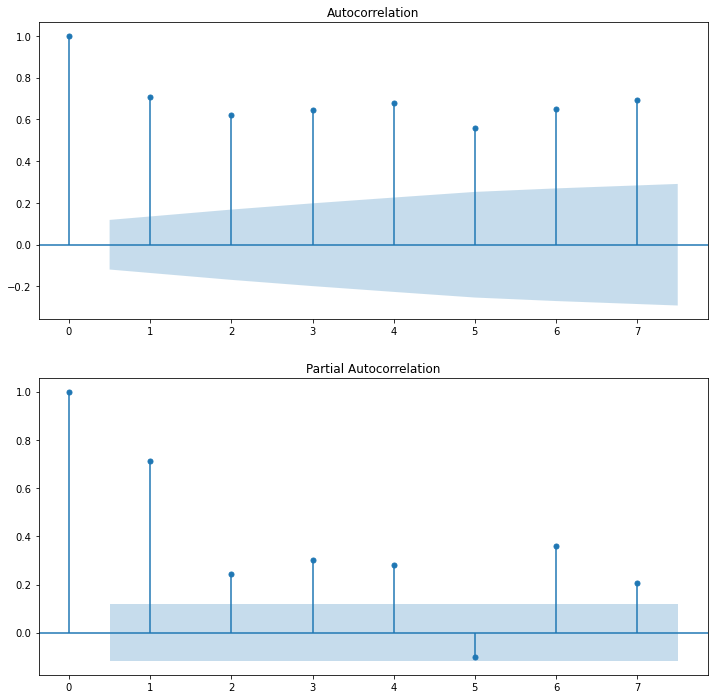

In [549]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

plot_acf(df_covid, lags=7, ax=ax1)
plot_pacf(df_covid, lags=7, ax=ax2);

## ARIMA Model

* **p**: Order of autoregression (AR)
* **d**: Grade of differencing
* **q**: Order of moving average (MA)
* Arima can only be used on a stationary dataset

In [550]:
from statsmodels.tsa.arima_model import ARIMA

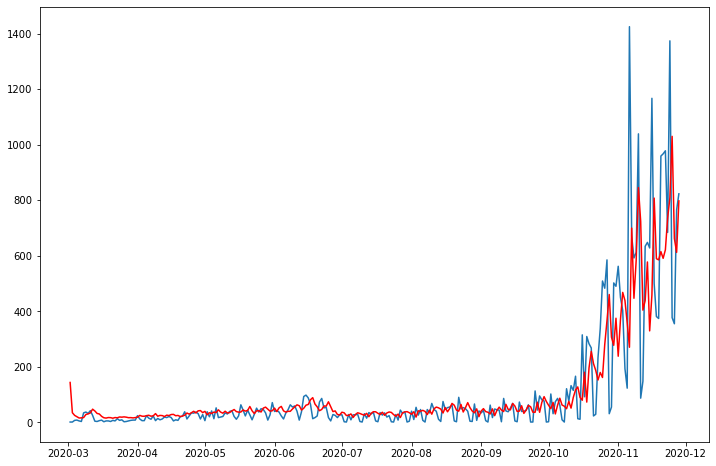

In [552]:
model=ARIMA(df_covid,order=(5,0,0)).fit()
#model = model.fit()

plt.figure(figsize=(12,8))
plt.plot(df_covid)
plt.plot(model.fittedvalues, color='red');

In [553]:
# Forecast upcoming 30 days
forecast = model.forecast(steps=30)[0]
df_forecast = pd.DataFrame(forecast, columns=['Upcoming 30 days'])
df_forecast

,Upcoming 30 days
0,523.001549
1,513.139629
2,622.500153
3,613.039338
4,522.872037
5,514.190050
6,535.770319
7,520.406835
8,487.424771
9,477.770644


In [565]:
df = df_forecast.copy()
df.shape

(30, 1)

In [573]:
date = pd.DataFrame(pd.date_range('2020-12-01', '2020-12-30', 
                     freq='D'), columns=['Date']) 
date

,Date
0,2020-12-01
1,2020-12-02
2,2020-12-03
3,2020-12-04
4,2020-12-05
5,2020-12-06
6,2020-12-07
7,2020-12-08
8,2020-12-09
9,2020-12-10


In [568]:
# Merge dataframes
test = pd.merge(skåne, datum, left_index=True, right_index=True)
df_covid.head()

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', freq='D')

In [561]:
df.head()

,Upcoming 30 days,Date
0,523.001549,NaT
1,513.139629,NaT
2,622.500153,NaT
3,613.039338,NaT
4,522.872037,NaT
